In [1]:
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn

In [2]:
# load data and params init
data = sio.loadmat('Data/EYB_fc.mat')
num_views =  int(data['num_modalities'])
# data = sio.loadmat('Data/ORL_mtv.mat')
# num_views = data['X'].shape[1]
dims = []
X = []
Img = {}

for i in range(0, num_views):
    I = []
    modality = str(i)
    modality_data = data['modality_' + modality].astype(np.float32)
    # modality_data = data['X'][0][i].astype(np.float32)
    for j in range(modality_data.shape[1]):
        temp = np.reshape(modality_data[:, j], [1, 32, 32])
        I.append(temp)
    Img[modality] = np.transpose(np.array(I), [0, 1, 3, 2])
    X.append(Img[modality])
    dims.append(X[i].shape[1])

labels = data['Label'][0]
# labels = data['gt'][:, 0]
labels = np.array(labels)
num_classes = labels.max()
batch_size = X[0].shape[0]
lr = 3e-4

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_sizes):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels[0], kernel_size=kernel_sizes[0], stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels[0], hidden_channels[1], kernel_size=kernel_sizes[1], stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels[1], hidden_channels[2], kernel_size=kernel_sizes[2], stride=2, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, hidden_channels, input_channels, kernel_sizes):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_channels[2], hidden_channels[1], kernel_size=kernel_sizes[2], stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels[1], hidden_channels[0], kernel_size=kernel_sizes[1], stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels[0], input_channels, kernel_size=kernel_sizes[0], stride=2, padding=1, output_padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.decoder(x)

In [4]:
from torch.nn.functional import normalize

class ConvAE(nn.Module):
    def __init__(self, input_dims, hidden_dim, kernels, samples, views, device):
        super(ConvAE, self).__init__()
        self.input_dims = input_dims
        self.hidden_dims = hidden_dim
        self.view_number = views

        self.encoders = []
        self.decoders = []
        self.batch_size = samples

        for v in range(views):
            self.encoders.append(Encoder(input_dims[v], hidden_dim, kernels).to(device))
            self.decoders.append(Decoder(hidden_dim, input_dims[v], kernels).to(device))

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, multi_view_data):
        rec_multi_data = []
        low_level_features = []
        for v in range(self.view_number):
            # get one single-view data
            one_view_data = multi_view_data[v]
            # get view-specific low-level feature
            one_view_low_level_feature = self.encoders[v](one_view_data)
            one_view_rec_data = self.decoders[v](one_view_low_level_feature)
            rec_multi_data.append(one_view_rec_data)
            low_level_features.append(one_view_low_level_feature)

        return rec_multi_data, low_level_features

In [5]:
# transfer data to Tensor format
kernel_size = [3, 3, 3]
n_hidden = [10, 20, 30]
dims = [1, 1, 1, 1, 1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_views_tensors = [torch.from_numpy(arr).to(device) for arr in X]
model = ConvAE(input_dims=dims, hidden_dim=n_hidden, kernels=kernel_size, samples=batch_size, views=num_views, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.)

In [6]:
from tqdm import tqdm
epoch_iter = tqdm(range(10000))
for epoch in epoch_iter:
    total_loss = 0
    mse = torch.nn.MSELoss()
    model.train()
    optimizer.zero_grad()
    rec_data, _ = model.forward(all_views_tensors)
    loss_list = []
    for v in range(num_views):
        if v == 0:
            loss_list.append(1 * mse(rec_data[v], all_views_tensors[v]))
        else:
            loss_list.append(1 * mse(rec_data[v], all_views_tensors[v]))
    loss = sum(loss_list)
    loss.backward()
    optimizer.step()
    total_loss = total_loss + loss.item()
    epoch_iter.set_description(f"# Epoch {epoch}, train_loss: {total_loss:.4f}, rec loss: {loss.item():.4f}")

# Epoch 9999, train_loss: 47.3062, rec loss: 47.3062: 100%|██████████| 10000/10000 [09:13<00:00, 18.07it/s] 


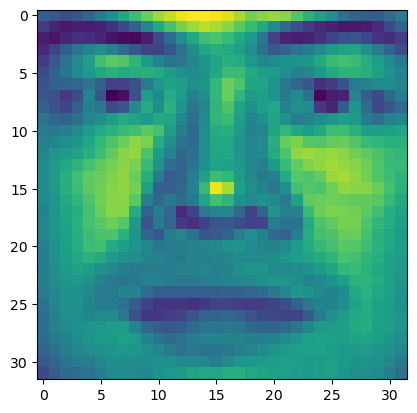

In [7]:
import matplotlib.pyplot as plt

plt.imshow(Img['0'][100][0])
plt.show()

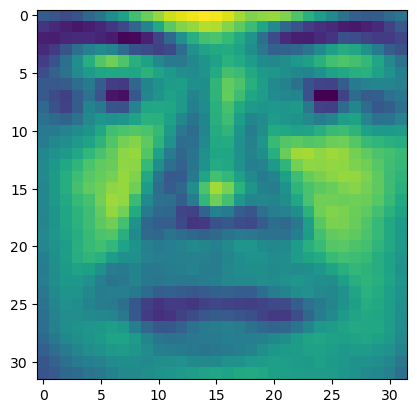

In [8]:
plt.imshow(rec_data[0].detach().cpu().numpy()[100][0])
plt.show()

In [9]:
class ConvAEwithSR(nn.Module):
    def __init__(self, input_dims, hidden_dim, kernels, samples, views, device):
        super(ConvAEwithSR, self).__init__()
        self.input_dims = input_dims
        self.hidden_dims = hidden_dim
        self.view_number = views

        self.encoders = []
        self.decoders = []
        self.batch_size = samples

        for v in range(views):
            self.encoders.append(Encoder(input_dims[v], hidden_dim, kernels).to(device))
            self.decoders.append(Decoder(hidden_dim, input_dims[v], kernels).to(device))

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)
        self.common_exp = nn.Parameter(1.0e-8 * torch.ones(samples, samples, dtype=torch.float32).cuda(), requires_grad=True)

    def forward(self, multi_view_data):
        low_level_features = []
        low_level_rec_features = []
        rec_multi_data = []
        z_common = self.common_exp - torch.diag(torch.diag(self.common_exp))
        for v in range(self.view_number):
            one_view_data = multi_view_data[v]
            one_view_low_level_feature = self.encoders[v](one_view_data)
            low_level_features.append(one_view_low_level_feature)

            # 依据低阶特征，学习视图特定自表示系数矩阵
            rec_latent = torch.matmul(z_common, one_view_low_level_feature.view(self.batch_size, -1))
            rec_latent = torch.reshape(rec_latent, shape=one_view_low_level_feature.size())
            low_level_rec_features.append(rec_latent)
            # 依据自表示重构的低维表征进行数据重建
            one_view_rec_data = self.decoders[v](rec_latent)
            rec_multi_data.append(one_view_rec_data)

        return low_level_features, low_level_rec_features, rec_multi_data, z_common

In [13]:
from utils import thrC, post_proC, err_rate

# start train ae with self-exp
reg1 = 1.0
reg2 = 1.0 * 10 ** (num_classes / 10.0 - 3.0)
epoch_iter = tqdm(range(2000))
display_step = 100

sr_model = ConvAEwithSR(input_dims=dims, hidden_dim=n_hidden, kernels=kernel_size, samples=batch_size, views=num_views, device=device)
sr_model.to(device)
optimizer = torch.optim.Adam(sr_model.parameters(), lr=lr, weight_decay=0.)
parameters_initAE = dict([(name, param) for name, param in model.named_parameters()])
for name, param in sr_model.named_parameters():
    if name in parameters_initAE:
        param_pre = parameters_initAE[name]
        param.data = param_pre.data

for epoch in epoch_iter:
    total_loss = 0
    mse = torch.nn.MSELoss()
    sr_model.train()
    latent_features, rec_latent_features, rec_data, z_common = sr_model.forward(all_views_tensors)
    rec_loss_list = []
    rec_latent_list = []
    for v in range(num_views):
        if v == 0:
            rec_loss_list.append(1 * mse(rec_data[v], all_views_tensors[v]))
            rec_latent_list.append(1 * mse(latent_features[v], rec_latent_features[v]))
        else:
            rec_loss_list.append(1 * mse(rec_data[v], all_views_tensors[v]))
            rec_latent_list.append(1 * mse(latent_features[v], rec_latent_features[v]))
    rec_data_loss = sum(rec_loss_list)
    rec_latent_loss = sum(rec_latent_list)
    reg_z_loss = torch.sum(torch.pow(z_common, 2.0))
    loss = (reg2 / 2) * rec_data_loss + 1 * reg_z_loss + (reg1 / 2) * rec_latent_loss

    if (epoch + 1) % display_step == 0:
        alpha = max(0.4 - (num_classes - 1) / 10 * 0.1, 0.1)
        Coef = thrC(z_common.detach().cpu().numpy(), alpha)
        y_hat, L = post_proC(Coef, labels.max())
        missrate_x, nmi, ari = err_rate(labels, y_hat)
        acc = 1 - missrate_x
        print("accuracy: %.4f" % acc, "NMI: %.4f" % nmi, "ARI: %.4f" % ari)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss = total_loss + loss.item()
    epoch_iter.set_description(f"# Epoch {epoch}, rec_loss: {rec_data_loss:.4f}, self_exp_loss: {rec_latent_loss.item():.4f}, total_loss: {loss.item()}")

print("%d subjects:" % num_classes)
print("ACC: %.4f%%" % (acc * 100))
print("NMI: %.4f%%" % (nmi * 100))
print("ARI: %.4f%%" % (ari * 100))

# Epoch 98, rec_loss: 2190.2390, self_exp_loss: 2134.1606, total_loss: 8004.3056640625:   5%|▍         | 99/2000 [00:07<02:13, 14.21it/s] 

accuracy: 0.8754 NMI: 0.9040 ARI: 0.8143


# Epoch 199, rec_loss: 1368.5129, self_exp_loss: 1474.9663, total_loss: 5106.373046875:  10%|▉         | 199/2000 [00:25<02:06, 14.20it/s]  

accuracy: 0.9224 NMI: 0.9368 ARI: 0.8826


# Epoch 298, rec_loss: 1062.6627, self_exp_loss: 1185.3242, total_loss: 4016.53125:  15%|█▍        | 299/2000 [00:32<02:00, 14.09it/s]       

accuracy: 0.9666 NMI: 0.9581 ARI: 0.9317


# Epoch 398, rec_loss: 889.6144, self_exp_loss: 1003.5558, total_loss: 3397.68701171875:  20%|█▉        | 399/2000 [00:45<01:53, 14.15it/s]  

accuracy: 0.9719 NMI: 0.9646 ARI: 0.9432


# Epoch 498, rec_loss: 775.4612, self_exp_loss: 873.0999, total_loss: 2988.761962890625:  25%|██▍       | 499/2000 [00:57<01:46, 14.12it/s] 

accuracy: 0.9773 NMI: 0.9703 ARI: 0.9536


# Epoch 598, rec_loss: 693.7070, self_exp_loss: 771.7800, total_loss: 2695.32080078125:  30%|██▉       | 599/2000 [01:10<01:38, 14.21it/s] 

accuracy: 0.9769 NMI: 0.9697 ARI: 0.9528


# Epoch 699, rec_loss: 632.5198, self_exp_loss: 693.9490, total_loss: 2477.47265625:  35%|███▍      | 699/2000 [01:28<01:31, 14.20it/s]    

accuracy: 0.9802 NMI: 0.9742 ARI: 0.9593


# Epoch 798, rec_loss: 586.7072, self_exp_loss: 627.1967, total_loss: 2312.316162109375:  40%|███▉      | 799/2000 [01:35<01:25, 14.11it/s]

accuracy: 0.9827 NMI: 0.9773 ARI: 0.9645


# Epoch 898, rec_loss: 547.8844, self_exp_loss: 572.2501, total_loss: 2174.29638671875:  45%|████▍     | 899/2000 [01:49<01:17, 14.25it/s] 

accuracy: 0.9810 NMI: 0.9749 ARI: 0.9610


# Epoch 998, rec_loss: 524.3977, self_exp_loss: 530.1822, total_loss: 2090.217041015625:  50%|████▉     | 999/2000 [02:02<01:10, 14.21it/s]

accuracy: 0.9818 NMI: 0.9758 ARI: 0.9626


# Epoch 1098, rec_loss: 495.6324, self_exp_loss: 498.8108, total_loss: 1993.9613037109375:  55%|█████▍    | 1099/2000 [02:15<01:03, 14.25it/s]

accuracy: 0.9827 NMI: 0.9767 ARI: 0.9645


# Epoch 1198, rec_loss: 473.6578, self_exp_loss: 464.6779, total_loss: 1917.0460205078125:  60%|█████▉    | 1199/2000 [02:28<00:56, 14.17it/s]

accuracy: 0.9835 NMI: 0.9777 ARI: 0.9660


# Epoch 1298, rec_loss: 469.3971, self_exp_loss: 443.8507, total_loss: 1901.870361328125:  65%|██████▍   | 1299/2000 [02:42<00:49, 14.22it/s] 

accuracy: 0.9835 NMI: 0.9777 ARI: 0.9661


# Epoch 1398, rec_loss: 453.1798, self_exp_loss: 420.1242, total_loss: 1846.8240966796875:  70%|██████▉   | 1399/2000 [02:55<00:42, 14.20it/s]

accuracy: 0.9831 NMI: 0.9773 ARI: 0.9653


# Epoch 1498, rec_loss: 424.7965, self_exp_loss: 391.5692, total_loss: 1750.2457275390625:  75%|███████▍  | 1499/2000 [03:09<00:35, 14.19it/s]

accuracy: 0.9831 NMI: 0.9773 ARI: 0.9652


# Epoch 1598, rec_loss: 420.0346, self_exp_loss: 379.0332, total_loss: 1735.70849609375:  80%|███████▉  | 1599/2000 [03:22<00:28, 14.01it/s]  

accuracy: 0.9831 NMI: 0.9770 ARI: 0.9651


# Epoch 1698, rec_loss: 405.7560, self_exp_loss: 361.4640, total_loss: 1687.870849609375:  85%|████████▍ | 1699/2000 [03:36<00:21, 14.21it/s] 

accuracy: 0.9827 NMI: 0.9764 ARI: 0.9643


# Epoch 1798, rec_loss: 413.5644, self_exp_loss: 370.4630, total_loss: 1722.6102294921875:  90%|████████▉ | 1799/2000 [03:50<00:14, 14.13it/s]

accuracy: 0.9835 NMI: 0.9776 ARI: 0.9660


# Epoch 1898, rec_loss: 387.1513, self_exp_loss: 336.9921, total_loss: 1627.75390625:  95%|█████████▍| 1899/2000 [04:04<00:07, 14.17it/s]     

accuracy: 0.9839 NMI: 0.9781 ARI: 0.9668


# Epoch 1998, rec_loss: 409.8066, self_exp_loss: 354.6065, total_loss: 1712.643798828125: 100%|█████████▉| 1999/2000 [04:18<00:00, 14.13it/s] 

accuracy: 0.9839 NMI: 0.9786 ARI: 0.9669


# Epoch 1999, rec_loss: 404.2211, self_exp_loss: 350.4496, total_loss: 1693.0809326171875: 100%|██████████| 2000/2000 [04:25<00:00,  7.53it/s]

38 subjects:
ACC: 98.3911%
NMI: 97.8578%
ARI: 96.6891%


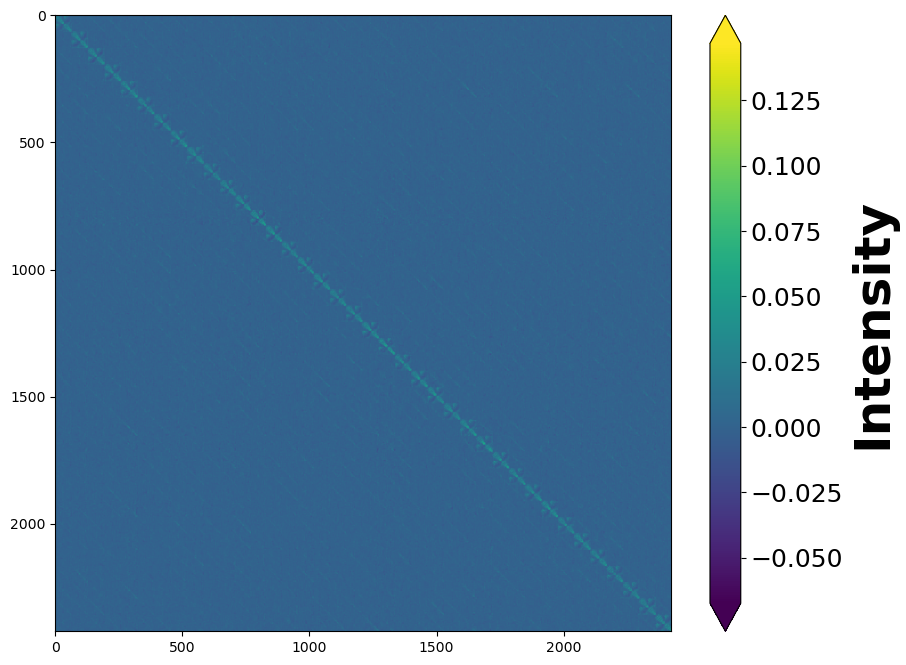

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
cax = plt.imshow(z_common.detach().cpu().numpy())
# set up colorbar
cbar = plt.colorbar(cax, extend='both', drawedges = False)
cbar.set_label('Intensity',size=36, weight='bold')
cbar.ax.tick_params(labelsize=18)
plt.show()

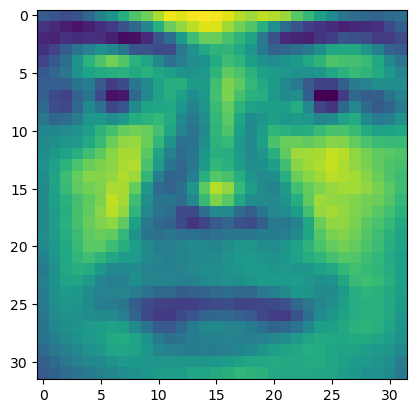

In [15]:
plt.imshow(rec_data[0].detach().cpu().numpy()[100][0])
plt.show()